# NLP of Whatsapp conversation

#### This Notebook has 3 sections:
#####  1) Sentiment Vs. Time
#####  2) Emojis 🙂, POS-tagging, Lexical Diversity and Classifying Dialogue (with a Naive Bayes Classifier)
#####  3) "Non-Text Stuff" - daily frequency of messages

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords   # may need to download (see below)
from nltk.sentiment.vader import SentimentIntensityAnalyzer   # again, may need to download (see below)
%matplotlib inline 

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


N.B. If an nltk import doesn't work/ nltk resource not available in a cell:
#### In cmd prompt: 
$python

\>import nltk

\>nltk.download()

#### In the explorer:
choose vader_lexicon (under models) [Or whatever other model is required] -> download

### Read in data:
To download Whatsapp data: In a chat, click on the chat name/ contacts name (at the top) and then near the bottom of the info page click on 'export chat' without media. The chat can then be saved as a zip file which needs to be unzipped and the csv placed in  the 'data' folder.

\* For privacy, I've done a find and replace-all of the names of people in the chat, re-naming them Person_1 and Person_2

\** I also have their consent to plot their/ our anonymised data

In [2]:
# read in the whatsapp txt file (unzipped and placed in data directory)
# Here I've done a find and replace all for the peoples names
with open('data/_chat.txt') as f:
    content = f.readlines()

content = [x.strip() for x in content] 

In [3]:
content[:5]

['[02/07/2017, 5:47:33 pm] Person_1: Hey there! Sorry I was appallingly slow at sending you a message',
 "[02/07/2017, 5:48:24 pm] Person_1: Been a manic weekend. Parents had a big party so I've been up in (the real) shire helping them prep for it and clear up after",
 "[02/07/2017, 5:48:44 pm] Person_1: How's your weekend been?",
 "[02/07/2017, 8:10:52 pm] Person_2: Hey Person_1! No worries at all! I've been super busy with stuff this weekend too",
 '[02/07/2017, 8:12:35 pm] Person_2: Oo, I dunno about the shire bit...']

# 1) Sentiment Vs. time:

For this I will need each message (row of data) with the; associated date (& time), Person (who sent the message) and the polarity of the message. I won't necesarrily need the actual message itself, instead just its associated polarity. i.e. a row something like:

<i>2017-07-25, Person_1, 0.5</i>

To calculate the polarity of the message I'll use the NLTK Vader Sentimemt Intensity Analyzer. It works really well with informal messages (and tweets) - being optimised for this. Another useful feature is that it can calculate the sentiment of non-word messages, e.g. ': )'

However, it's not perfect, so caution should be taken when analysing it's results in too finer detail. In my opinion, it works really well when aggregating over a substantial block of text e.g. a days worth of messages. 

In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [5]:
sid = SentimentIntensityAnalyzer() 

##### e.g.

In [6]:
sid.polarity_scores(':)')

{'compound': 0.4588, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0}

In [7]:
sid.polarity_scores(':(')

{'compound': -0.4404, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [8]:
sid.polarity_scores("This is a REALLY happy sentence!")

{'compound': 0.807, 'neg': 0.0, 'neu': 0.291, 'pos': 0.709}

##### Firstly, to get a feel for things, I'll do a fairly rough run-through and just plot the mean polarity of each days messages:

In [9]:
pol_lst=[]
date_lst=[]
i=0

for line in content:
    
    try:
    
        text = nltk.sent_tokenize(line.split(':')[3].replace('\n',' '))
        date = line.split('[')[1].split(',')[0]
        
        for token in text:
            
            ss = sid.polarity_scores(token)  
            pol_lst.append(ss['compound'])
            date_lst.append(date)
            
    except:
        
        #print(i, line) # uncomment this to print the message that couldn't be read
        
        pass
    #i+=1   # uncomment this to see the line number that the message fails to be read

Open in Notepad++

#### Create a datframe from the date and polarity lists

In [10]:
df = pd.DataFrame({'date' : date_lst, 'pol' : pol_lst})

In [11]:
df[:5]

,date,pol
0,02/07/2017,0.0000
1,02/07/2017,-0.5106
2,02/07/2017,0.0000
3,02/07/2017,0.7579
4,02/07/2017,0.0000


#### Calculate the mean polarity for each day:

In [12]:
df2 = df.groupby('date').mean()

In [13]:
df2.index = pd.to_datetime(df2.index, format='%d/%m/%Y')

In [14]:
df2 = df2.sort_index()

In [15]:
df2['date'] = df2.index

In [16]:
df2[:5]

,pol,date
date,,
2017-07-02,0.278509,2017-07-02
2017-07-03,0.278825,2017-07-03
2017-07-05,0.339942,2017-07-05
2017-07-06,0.083738,2017-07-06
2017-07-07,0.225321,2017-07-07


The mean polarity for all messages for each day

#### Visualise this with a basic plot:

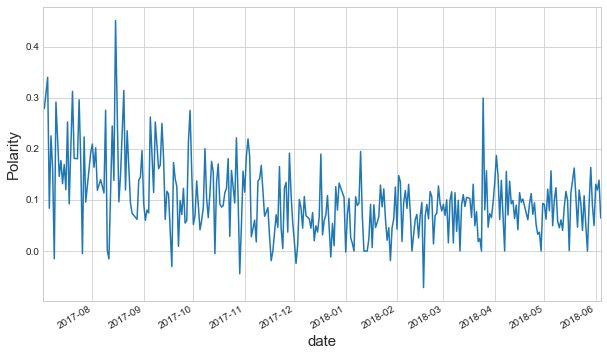

In [17]:
sns.set_style("whitegrid")

plt.figure()
ax = df2.plot(figsize=(10,6), legend=False)

ax.set_ylabel('Polarity')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

# plt.savefig('plots/rough_pol_vs_time')  # uncomment to save

So that worked quite well and a general trend can be drawn from the plot. However, upon doing this, there were a few issues and points that could be improved:

- the sentiment intensity analyzer doesn't work on emojis
- the plot doesn't differentiate between both participants of the chat
- passes on ~30 lines
- splitting on ':' chracter removes further ':' characters in text which is not good for calculating a sentiment associated to e.g. a ': )' or ': (' face

##### For example, this is what happens when splitting on ':' ... anything after e.g. a ': )' is lost 

In [18]:
print('[02/07/2017, 5:47:33 pm] Person_1: Hey there! : )'.split(':')[3:])

[' Hey there! ', ' )']


##### To add back in ':' from split, and keep smiley faces for polarity calculation...

In [19]:
print(':'.join('[02/07/2017, 5:47:33 pm] Person_1: Hey there! : )'.split(':')[3:]))

 Hey there! : )


##### Use the 'emoji' library to convert the emoji to their unicode description. This works fairly well, so will be fine for here.
\* There's also a paper online which has scientifically calculated the sentiment of each emoji, so this could be something to look at in the future (if I was going to analyse in much finer detail)
http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0144296

In [20]:
import emoji

In [21]:
test = content[15:25]  # I know these lines contain an emoji...

In [22]:
for line in test:
    for c in line:
        
        if c in emoji.UNICODE_EMOJI:
            print(c)
            #print(c)
            print(emoji.demojize(c).replace('_',' ').replace(':','.'))
            print(sid.polarity_scores(emoji.demojize(c).replace('_',' ').replace(':','.'))['compound'])

😁
.grinning face with smiling eyes.
0.6705
🙂
.slightly smiling face.
0.4033


Opening text file in ATOM and viewing the 'invisible characters':

normally Cr and Eol

failing on just EOL

However, this is pretty much just for hyperlinks, so for this conversation it's ok to pass on them as they can't really be used in this context

### Putting everything back together:
##### Incorporating Emoji conversion and ':' re-addition from above...
Here I'll also be conscious of keeping both participants of the chat seperate, i.e. not just taking the mean for each date...

In [23]:
final = defaultdict(list)
i=1 # used as final dictioanry key

for line in content[1:]:
        
        try:
            date = line.split('[')[1].split(',')[0] # strip just the date
            person = line.split(':')[2][7:]  # strip the persons name
            text = ':'.join(line.split(':')[3:])  # strip just the text
            # joins back on the ':' -> useful for smiley face ':)'
            # which has sentiment associated
         
            # convert emojis to their Unicode description ...works well with sentiment
            # loop through each character to check if it's an emoji, then convert
            for c in text:
                if c in emoji.UNICODE_EMOJI:
                    text = text.replace(c, emoji.demojize(c).replace('_',' ').replace(':','.'))
            
            # tokenize the sentence, i.e. split up into chunks based on punctuation.   
            sentence = nltk.sent_tokenize(text)
            num = np.array([])
            
            for token in sentence:
                # calculate sentiment of token and add to the final dictionary 
                # along with person and date metrics
                ss = sid.polarity_scores(token)
                
                final[i] = [ss['compound'], person, date, token]
                i+=1
                
        except:
            pass
        

In [24]:
df= pd.DataFrame(final).T  # convert dictionary to a dataframe, makes process of plotting straightforward

In [25]:
df.columns = ['pol', 'name', 'date', 'token']

In [26]:
#df[['pol','token', 'name']].sort_values('pol')[:10] # uncomment this to see who has sent the most negative messages

In [27]:
len(df)

20973

In [28]:
df[:5]

,pol,name,date,token
1,0,Person_1,02/07/2017,Been a manic weekend.
2,0.7579,Person_1,02/07/2017,Parents had a big party so I've been up in (th...
3,0,Person_1,02/07/2017,How's your weekend been?
4,0,Person_2,02/07/2017,Hey Person_1!
5,-0.6476,Person_2,02/07/2017,No worries at all!


In [29]:
df.dtypes

pol      object
name     object
date     object
token    object
dtype: object

In [30]:
df['pol'] = df['pol'].apply(lambda x : float(x)) # convert polarity to a float

##### Calculate the mean sentiment of all messages for each person, each day:

In [31]:
df2 = df.groupby(['date', 'name'], as_index=False).agg('mean')

In [32]:
df2[:5]

,date,name,pol
0,01/01/2018,Person_1,0.081400
1,01/01/2018,Person_2,-0.077030
2,01/02/2018,Person_1,0.030786
3,01/02/2018,Person_2,0.079771
4,01/03/2018,Person_1,0.125508


##### Create a 'combined' dataset, based on the mean polarity of both people in the chat:
Similar to above, just dont need to group-by name as well

In [33]:
df3 = df.groupby(['date'], as_index=False).agg('mean')

In [34]:
df3['name'] = 'Combined'

##### Join 'combined' onto 'original':

In [35]:
final =pd.concat([df2, df3])

In [36]:
final['date'] = pd.to_datetime(final.date, format='%d/%m/%Y') # need to chnage 'date' to a datetime object

In [37]:
final = final.sort_values('date')

In [38]:
final[:6]

,date,name,pol
17,2017-07-02,Combined,0.321162
34,2017-07-02,Person_1,0.298490
35,2017-07-02,Person_2,0.341773
59,2017-07-03,Person_2,0.249489
29,2017-07-03,Combined,0.271458
58,2017-07-03,Person_1,0.337367


##### create a numerical column that maps to the date. Makes splotting more straightforward, as some of the below plots don't like having an x-axis of type datetime...
An easy way to do this is via a dense rank:

In [39]:
final['x'] = final['date'].rank(method='dense', ascending=True).astype(int)

In [40]:
final[:6]

,date,name,pol,x
17,2017-07-02,Combined,0.321162,1
34,2017-07-02,Person_1,0.298490,1
35,2017-07-02,Person_2,0.341773,1
59,2017-07-03,Person_2,0.249489,2
29,2017-07-03,Combined,0.271458,2
58,2017-07-03,Person_1,0.337367,2


#### Plotting polarity for each person (and combined) against time:

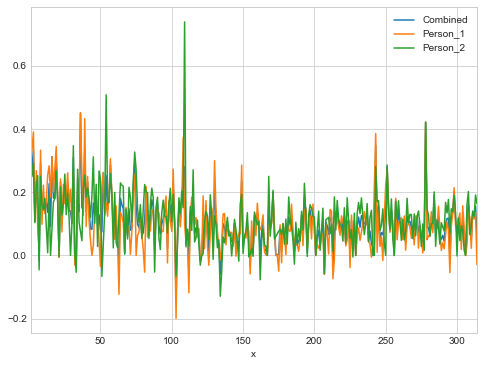

In [41]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8,6))

for label, df in final.groupby('name'):
    df.plot(x='x', y='pol', ax=ax, label=label)
    
plt.legend()

This is ok, but it's really quite difficult to view any significant differences between the two people. To smooth out the data a bit (which will have the effect of normalising any local high and low points) I'll create a rolling mean for the sentiment on a 20 day basis

### With Rolling Mean:

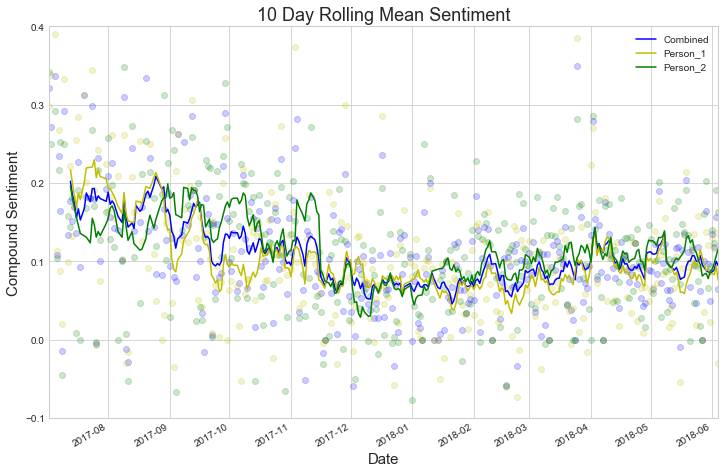

In [42]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,8))
colours=['b','y','g']
i=0

for label, df in final.groupby('name'):
    
    new=df.reset_index()
    new['rol'] = new['pol'].rolling(10).mean() # rolling mean calculation on a 10 day basis
    
    g = new.plot(x='date', y='rol', ax=ax, label=label, color=colours[i]) # rolling mean plot
    plt.scatter(df['date'].tolist(), df['pol'], color=colours[i], alpha=0.2) # underlying scatter plot
    
    i+=1

ax.set_ybound(lower=-0.1, upper=0.4)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Compound Sentiment', fontsize=15)

g.set_title('10 Day Rolling Mean Sentiment', fontsize=18)

#plt.savefig('plots/sentiment_time')   # uncomment to save

This is much better: calculating a rolling mean of the polarity makes the data a lot clearer to see what's going on. Each person experiences periods of local highs and lows, and their sentiment ebbs and flows over time. 

Another point is that when one person seems to be having a dip in sentiment (i.e. having a down day) the other person usually compensates this and raises their sentiment to try and bring them back up. 
This is really interesting to see this visually!

[Note: The first 20 days don't have an associated rolling mean as the mean value is calculated from the 20 days previous to the current day] 

# 2) Emojis, POS-tagging, Lexical Diversity and Classifying Dialogue:

As this will be more 'in-depth' NLP (instead of formatting the raw whatsapp data into a pandas dataframe, which was useful above for plotting purposes) I'll instead format the data into a dictionary - which is more 'standard practice' when working with textual data.

All messages, tokenized and appended to separate lists, based on the person who sent the message.

In [43]:
ppl=defaultdict(list)

for line in content:
    
    try:
        # date = line.split('[')[1].split(',')[0]
        person = line.split(':')[2][7:]
        text = nltk.sent_tokenize(':'.join(line.split(':')[3:]))
      
        ppl[person].extend(text)   # If key exists: extend (value) list, if not create a new key with text extended to list
                 
    except:
        #print('Error!')
        #print(line)   # uncomment to examine failed line
        
        pass
        
        

##### Dictionary -> Key is the person who sent the message, the value is a sentence-tokenized list of all the messages they've sent.

In [44]:
ppl['Person_2'][:5]

[' Hey Person_1!',
 'No worries at all!',
 "I've been super busy with stuff this weekend too",
 ' Oo, I dunno about the shire bit...',
 ' Oh cool!']

### <u>Analysing Total Emoji Useage</u>



#### Function to extract all emojis from a string 

In [45]:
def extract_emojis(strng):
  return ''.join(c for c in strng if c in emoji.UNICODE_EMOJI)

In [46]:
extract_emojis(str('hello 😁'))

'😁'

#### Iterate through the two keys, extract all emojis from each persons list of words and count their most used: 

In [47]:
for key, val in ppl.items():
    
    emojis=extract_emojis(str(ppl[key]))
    count = Counter(emojis).most_common()[:10]
    
    print("{}'s emojis:\n {} \n".format(key, emojis))
    print("Most common: {}\n\n".format(count))

Person_1's emojis:
 😏🕺🏼🍻😮🤤😭😏💁🏼😏👏🙏🐳🐋😏😱🙄😳☺😭🚀💫⭐✨💥🍕🍕😏😊😘🙄💭😭😭😭😭😏✅😱😏😭🙄😘😘😘😘😭😭😭😭😭😭🍸😘😘😅😘😭👏💪😭🙅♂🙆♂🙋♂💁♂😘🎉🎉🎉🎉🎉🎉🎉🎉🎉😊😘🙄😴😉🕺🏼😭😎😭🙄😘😘😘👏😩😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭📞🎉😘😀😚😱👏🏏😏🚂🤓👏🙄🙌😘😘😏😭😭🙌😏😔😭😘🤰🏼😘🙄🙄😰🙋🏼♀😭🙄😍🤓👏😭😭😭😭😭😘🍕💩☹🙋🏼♀😘😴🚲😘😘😘😭☹😗😙😚😚🤔🤝🍻🎂✈😘👌😰😘🔺🔥😩😘💨😚😱😢😭😭😭😭😭😭😭😭😭😭😗🤔🤔🤔🤔🤔🤔🤔👀👏😇😗😚😘🙄☹😘😩😚😇⚡💥🔥☹😭😩😭😰😱😅😅😍😞👏👏👏👏👏👏😘😘😊😘😘😍😘🙄😏😘😘🙄😘👀😘😘👀😘😘😘🥕😘😘😘😘😘😘😘😘😭😘😘🖕🏻😘🌇😘😘😘🙄😪🤧😘🥚😘😘😘😘😘😘😘😘😘😘😱😘😭😭😘🆘❌‼⭕♨🚫⛔🚷🖍📌📍✂📕📮🔻☎⏰🚨🚒🚗🥊🏓🍷🌶🍅🍎☄🌹🎒👠⛑😎😘😘😘😘😙👀🙄😭😭😭😭😭😭😘😘😘🥚😘🙄🙄😘 

Most common: [('😘', 77), ('😭', 68), ('🙄', 16), ('👏', 13), ('😏', 11), ('🎉', 10), ('🤔', 8), ('🏼', 6), ('😱', 6), ('😚', 6)]


Person_2's emojis:
 😁🙂🤓😅😀👍😂😬👻😁😂✌😴😬😬🙄🎉✌😂😪😒😬😐😬😁😬😁😏🤢😁😒😁😏😘😒😅😂💪👊😬😏💁♂😴😬😅😏😆🐬🙁😬🐬😁😁✌😁😁👊👮😕✌😁😁😐✌😱😩😬✌✌😂😘💇♂😁😁😁😅🙂😬🙁😁😁😕😴😁😏😁😘😅😴🙂🎉🎉🎉😁🚀🚀🚀😁😱✌🍕🍕😏👍😂😁😑😘🙄😁😘😬😂😁🎉🎉🎉✌☺😑😁😬🙂😱😂✌☺😁👊😁👊👍😏💁🏼😅😁😁😁😕✌🤓😂😘😁😁✌✌😘🙁😘😁🎉✌😘😘😘😘😅😁😁😁😁😂🙁😏😔✌😘😁😐😁✌🙂👍😘😬😁✌😂🙋🏼😎😁🤓💩😂😘😐😏✌🙂✌😘✌😁🤔✌🏋🏼♀😬🙂😁👊😁✌😁😁😏🤜🤛☹⚡😬🎯💪😁☹😞👋🙂😘😴😁😁🎉😁✌🙂😘😬✌👍😁💃👍👍👍👍😢☹🙁🙁👋😏😬😁✌😘🙁👍🙌🤓😏🎉💁♂😁😑😁😁😁🎉😁☹😕😢😬✌😞😬✌😬👍😁😏😁👍👍👊😁😧😘😪😁🎉🎉🎉😕👍😁👉😁👊😏😁😁😂😂😂🤳👌😁👌🙋🏼♀👋😐😐😁🙁😕👊😁🤔🤗🤙👍😬🤔🎉🎅🏻👍😁😁😁🤚😘🤚👍👊🙁🙁🙁🙄😘🙋🏼♀🤣😘🎉😬🙁😖💁♂😂😒🎉😗👏🤔🤐🙄👊😘😉😘🙂☹💰😏🎉😑😬👍👍👎🙋♂💁♂😁😁🙂☹🤔🦄🦄😬😆😴😁😁😁😍🏄♀👀😁🏄♀👍😬👊😬🤔😁🙄👌👍😫☹🤗😩👀😁💰🤔👍😁😰😳😣😟😘👀🤗🙂😅👍🤔🙂😁😁😣🕺😮🙂☹☹😑🤘☹😬🍳😘😬😘🤘🙋♂🙁🍓😢😁😂😂😂😁😘🐑😚😚😚🤞😁🙄😁🙋♂😴😘👍😁👊😑😒👍😑😬👍👍

### <u>Categorise Messages With A Naive Bayes Classifier</u>


Use the nltk nps_chat data to train a naive bayes model.

Each message in the dataset has already been classified into 1 of 15 categories:

'Greet', 'Statement', 'Emphasis', 'Clarify', 'whQuestion', 'ynQuestion',' Reject', 'nAnswer', 'yAnswer', 'Other', 'Bye', 'Emotion', 'System', 'Accept', 'Continuer'

In [48]:
# nltk.download('nps_chat')  # uncomment if not already downloaded...

In [49]:
posts = nltk.corpus.nps_chat.xml_posts()

#### Extract features from each message, tokenize by word

In [50]:
def extract_features(post):
    features = {}
    for word in nltk.word_tokenize(post):
        features['contains({})'.format(word.lower())] = True
    return features

In [51]:
fposts = [(extract_features(p.text), p.get('class')) for p in posts]

#### create a train and test set of the chat messages

In [52]:
test_size = int(len(fposts) * 0.1)
train_set, test_set = fposts[test_size:], fposts[:test_size]

#### train the model

In [53]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

#### Test accuracy against the test set of data

In [54]:
print(nltk.classify.accuracy(classifier, test_set))

0.6685606060606061


#### Not a perfect accuracy ...but should be ok for the purpose of comparing one persons message categories to the another at least

#### Some mini tests...

In [55]:
classifier.classify(extract_features('Hi there!'))

'Greet'

In [56]:
classifier.classify(extract_features('Do you want to watch a film later?'))

'ynQuestion'

In [57]:
classifier.classify(extract_features('Yes, that sounds good'))

'Accept'

##### Cool! seems to work ok for these few test cases.

#### Run on the whatsapp messages...

In [58]:
ppl_cat= {}
print("Types of messages sent by each member of the chat,"
      " as classified by a Naive Bayes Classifier trained on the nltk nps_chat dataset \n***\n")
for key, val in ppl.items():
    cat=[]
    for sent in val:
        cat.append(classifier.classify(extract_features(sent)))
        count = Counter(cat)
    ppl_cat[key] = count
    print("{}: {} \n\n".format(key, count.most_common()))

Types of messages sent by each member of the chat, as classified by a Naive Bayes Classifier trained on the nltk nps_chat dataset 
***

Person_1: [('Statement', 4746), ('Clarify', 2611), ('Emphasis', 1562), ('nAnswer', 519), ('whQuestion', 451), ('ynQuestion', 444), ('Reject', 396), ('Emotion', 269), ('Accept', 205), ('yAnswer', 148), ('Continuer', 115), ('Other', 70), ('System', 34), ('Bye', 32), ('Greet', 26)] 


Person_2: [('Statement', 3750), ('Emphasis', 1698), ('Clarify', 1682), ('ynQuestion', 591), ('nAnswer', 415), ('whQuestion', 404), ('Reject', 249), ('Accept', 143), ('Emotion', 90), ('Other', 76), ('yAnswer', 72), ('Continuer', 51), ('System', 38), ('Bye', 22), ('Greet', 18)] 




#### create a dataframe of this categorised data to plot

In [59]:
df = pd.DataFrame.from_dict(ppl_cat, orient='index')

In [60]:
df

,Greet,Statement,Clarify,whQuestion,Emphasis,ynQuestion,Reject,nAnswer,yAnswer,Other,Bye,Emotion,System,Accept,Continuer
Person_1,26,4746,2611,451,1562,444,396,519,148,70,32,269,34,205,115
Person_2,18,3750,1682,404,1698,591,249,415,72,76,22,90,38,143,51


#### Since each person has sent a different number of messages, normalize these counts:

In [61]:
df = df.div(df.sum(axis=1), axis=0).round(3)

In [62]:
df

,Greet,Statement,Clarify,whQuestion,Emphasis,ynQuestion,Reject,nAnswer,yAnswer,Other,Bye,Emotion,System,Accept,Continuer
Person_1,0.002,0.408,0.225,0.039,0.134,0.038,0.034,0.045,0.013,0.006,0.003,0.023,0.003,0.018,0.010
Person_2,0.002,0.403,0.181,0.043,0.183,0.064,0.027,0.045,0.008,0.008,0.002,0.010,0.004,0.015,0.005


#### Plot, for a better way of viewing the data

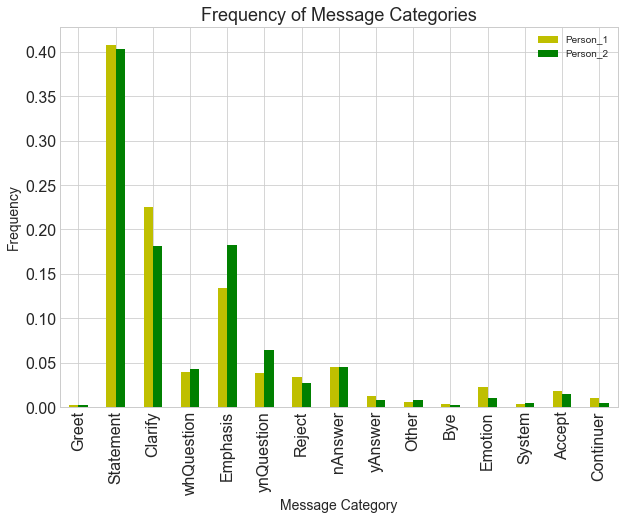

In [63]:
ax = df.T.plot(kind='bar', figsize=(10, 7), legend=True,
               fontsize=16, color=['y','g'])

ax.set_title("Frequency of Message Categories", fontsize= 18)
ax.set_xlabel("Message Category", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

#plt.savefig('plots/cat_message')   # uncomment to save
plt.show()


### <u>Wordcloud</u>

#### convert list to string and split individual words on a space -> list of individual words

In [64]:
p1s = ''.join(ppl['Person_1']).split()
p2s = ' '.join(ppl['Person_2']).split()

In [65]:
p2s[:5]

['Hey', 'Person_1!', 'No', 'worries', 'at']

In [66]:
stopwords = nltk.corpus.stopwords.words('english')

In [67]:
stopwords.append('<‎image omitted>')  # doesn't work

##### To plot Person_2's wordcloud:

In [68]:
filtered_words = [word for word in p2s if word not in stopwords]

In [69]:
filtered_words[:5]

['Hey', 'Person_1!', 'No', 'worries', 'all!']

In [70]:
p1sf = ' '.join(filtered_words)

In [71]:
wordcloud = WordCloud(width=1000, height=1000, margin=0).generate(p1sf)

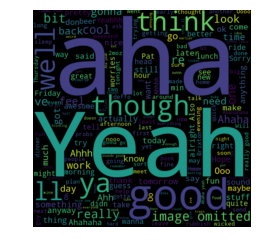

In [72]:
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('plots/wordcloud')

### <u>Lexical Diversity</u>

##### i.e. how many different words a person uses/ how big a persons vocabulary is (or at least choose to use)

In [73]:
def lexical_diversity(text):
    
    return len(set(text)) / len(text)

In [74]:
for key, value in ppl.items():
    wrds=[]
    
    for line in ppl[key]:       
        words = nltk.word_tokenize(line)
        wrds.extend(words)
        
    tagged = nltk.pos_tag(wrds, tagset='universal' )
    print("{}'s lexical diversity: {} \n".format(key, lexical_diversity(tagged)))

Person_1's lexical diversity: 0.11349681928363131 

Person_2's lexical diversity: 0.11650318092074337 



### <u>POS tagging</u>

In [75]:
# nltk.download('universal_tagset')   # if not downloaded already...

In [76]:
from nltk.stem.porter import *

In [77]:
stemmer = PorterStemmer()

In [78]:
wrds=[]
for line1 in ppl['Person_1']:
    
    words = nltk.word_tokenize(line1)
    wrds.extend(words)

In [79]:
tagged = nltk.tag.pos_tag(wrds, tagset='universal')

In [80]:
tggd = nltk.FreqDist(tag for (word, tag) in tagged)

In [81]:
tggd

FreqDist({'.': 3290,
          'ADJ': 6922,
          'ADP': 6710,
          'ADV': 7443,
          'CONJ': 2111,
          'DET': 5106,
          'NOUN': 18670,
          'NUM': 854,
          'PRON': 9153,
          'PRT': 2609,
          'VERB': 18235,
          'X': 168})

In [82]:
counts = Counter(stemmer.stem(word) for word, tag in tagged if tag == 'VERB' )

In [83]:
counts.most_common()[:10]

[('’', 1583),
 ('is', 600),
 ('have', 595),
 ('be', 564),
 ('do', 518),
 ('wa', 491),
 ('get', 392),
 ('can', 353),
 ('go', 346),
 ('omit', 342)]

# 3) "Non-Text Stuff"

### Frequency of messages by time of day each month

In [84]:
dates=[]
for line in content:
    try:
        dates.append(line.split('[')[1].split(']')[0])
    except:
        #print(line)   # examine the line that can't be read
        # print('oops')
        pass

In [85]:
date=[]
time=[]
for item in dates:
    date.append(item.split(',')[0])
    time.append(item.split(',')[1])

In [86]:
dates[:3]

['02/07/2017, 5:47:33 pm', '02/07/2017, 5:48:24 pm', '02/07/2017, 5:48:44 pm']

In [87]:
df = pd.DataFrame(dates, columns =['dtm'])

In [88]:
df.dtm = pd.to_datetime(df.dtm, format='%d/%m/%Y, %I:%M:%S %p')

In [89]:
df[:5]

,dtm
0,2017-07-02 17:47:33
1,2017-07-02 17:48:24
2,2017-07-02 17:48:44
3,2017-07-02 20:10:52
4,2017-07-02 20:12:35


In [90]:
df['float_time'] = df.dtm.dt.hour+df.dtm.dt.minute/60.0

In [91]:
df['year_month'] = df.dtm.dt.to_period('M')

In [92]:
df['day'] = df.dtm.dt.weekday_name

In [93]:
df['day_num'] = df.dtm.dt.dayofweek

In [94]:
df = df.sort_values('day_num')   # change this to 'year_month' if wanting to plot by this instead

In [95]:
df['freq'] = df.groupby('day')['day'].transform('count')

In [96]:
df[:4]

,dtm,float_time,year_month,day,day_num,freq
19624,2018-06-04 19:37:42,19.616667,2018-06,Monday,0,3152
6762,2017-12-18 20:52:43,20.866667,2017-12,Monday,0,3152
6761,2017-12-18 20:52:37,20.866667,2017-12,Monday,0,3152
6760,2017-12-18 20:52:22,20.866667,2017-12,Monday,0,3152


## Plot:

##### This seems to work best with latest version of seaborn (at the time of writing) -> version 0.8.1

#### NOTE: This can be changed to plot by 'year_month' instead of day instead by changing the necessary parameters in the plot 

### First, need to create a colour pallete ordered by the total number of messages for each day

In [97]:
pal = sns.cubehelix_palette(7, rot=-.25, light=.7)

#### Ordered list of days according to total message count 

In [98]:
days_freq = list(df.day.value_counts().index)
days_freq

['Wednesday', 'Tuesday', 'Thursday', 'Monday', 'Friday', 'Sunday', 'Saturday']

In [99]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#### This is essentially the current order of colours 

In [100]:
lst = list(zip(days, pal[::-1]))
lst 

[('Monday', [0.12071162840208301, 0.14526386650440642, 0.2463679091477368]),
 ('Tuesday', [0.18152581198633005, 0.24364059111738742, 0.37281834227732574]),
 ('Wednesday', [0.2426591079772084, 0.3511228226876375, 0.4852103253459974]),
 ('Thursday', [0.30463866738797124, 0.45571986933681846, 0.5751187147066701]),
 ('Friday', [0.37810168111401876, 0.5633546614344814, 0.6530658354036274]),
 ('Saturday', [0.46091631066717925, 0.662287611911293, 0.7165315069314769]),
 ('Sunday', [0.5632111255041908, 0.758620966612444, 0.7764634182455044])]

#### Reorder colours according to their index position in the 'days_freq' list

In [101]:
pal_reorder=[]

for i in days:
    #print(i)
    j=0
    for day in days_freq:
        
        if i == day:
            #print(lst[j][1])
            pal_reorder.append(lst[j][1])
        j+=1
        

In [102]:
pal_reorder   # colours ordered according to total message count for the day

[[0.30463866738797124, 0.45571986933681846, 0.5751187147066701],
 [0.18152581198633005, 0.24364059111738742, 0.37281834227732574],
 [0.12071162840208301, 0.14526386650440642, 0.2463679091477368],
 [0.2426591079772084, 0.3511228226876375, 0.4852103253459974],
 [0.37810168111401876, 0.5633546614344814, 0.6530658354036274],
 [0.5632111255041908, 0.758620966612444, 0.7764634182455044],
 [0.46091631066717925, 0.662287611911293, 0.7165315069314769]]

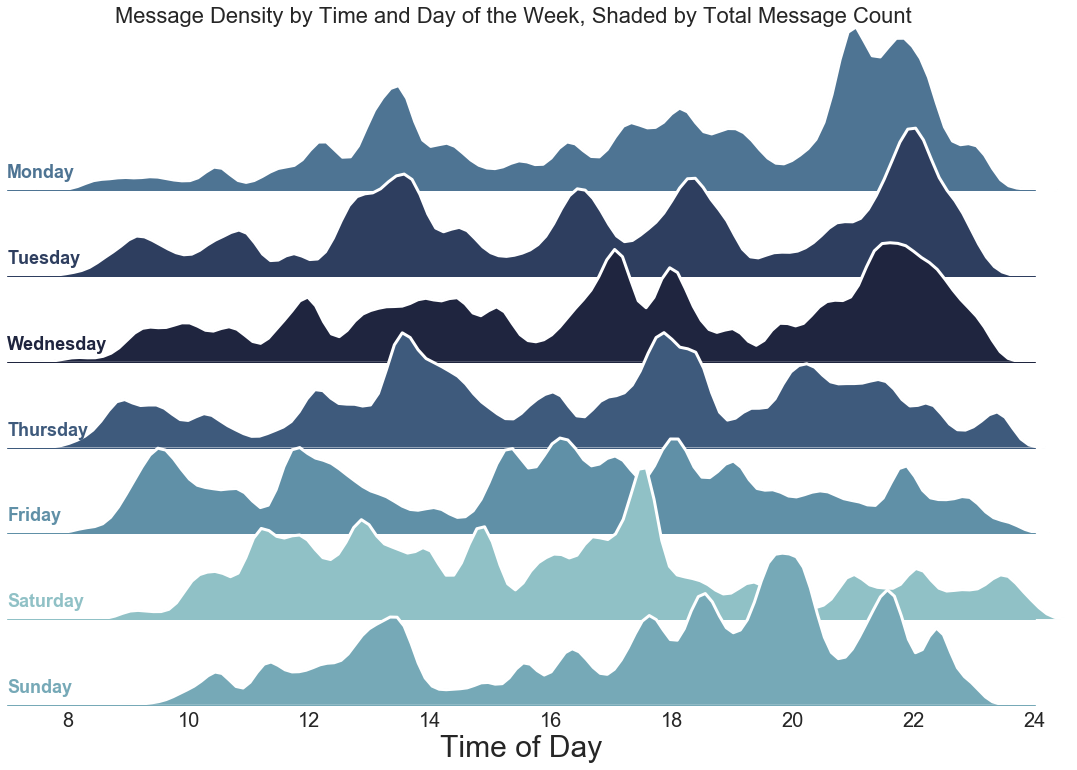

In [103]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(7, rot=-.25, light=.7)
g = sns.FacetGrid(df[(df.float_time > 8)], row="day", hue="day",   # change "day" to year_month if required
                  aspect=10, size=1.5, palette=pal_reorder, xlim=(7,24))

# Draw the densities in a few steps
g.map(sns.kdeplot, "float_time", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "float_time", clip_on=False, color="w", lw=3, bw=.2)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.1, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes, size=18)

g.map(label, "float_time")
g.set_xlabels('Time of Day', fontsize=30)
g.set_xticklabels(fontsize=20)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.5)
g.fig.suptitle('Message Density by Time and Day of the Week, Shaded by Total Message Count', fontsize=22)   
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

#g.savefig('plots/message_density_day.png')   # uncomment to save